# Post-processing for 2030ContractCase


## Packages

In [105]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle

import nygrid.run_nygrid as ng_run
import nygrid.nygrid as ng_grid
import nygrid.postprocessing as ng_post

In [106]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))


Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

In [107]:
# Cost modifiers
ext_cost_factor = 0.0
# fo_cost_factor = 1.0
fo_cost_factor = 0.5

# Simulation time settings
valid_days =14
lookahead_days = 2

valid_hours = 24 * valid_days
lookahead_hours = 24 * lookahead_days

sim_start_time = datetime(2018, 1, 1, 0, 0, 0)
sim_end_time = datetime(2018, 12, 31, 23, 0, 0)
timestamp_list = pd.date_range(sim_start_time, sim_end_time, freq=f'{valid_days}D')


## Read OPF results

In [108]:
sim_name = f'2030ContractCase_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030ContractCase')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030 = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030ContractCase.csv',
                                       esr_prop_file='esr_prop_2030ContractCase.csv',
                                       dcline_prop_file='dcline_prop_2030ContractCase.csv')
display(grid_prop_2030.keys())

grid_profile_2030 = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030.keys())

# Generator fuel types
display(grid_prop_2030['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030 = ng_grid.NYGrid(grid_prop=grid_prop_2030,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030.NB} and {nygrid_sim_2030.NBR}")
print(f"Number of loads: {nygrid_sim_2030.NL}")
print(f"Number of time periods: {nygrid_sim_2030.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'ST_FO6', 'CT_KER', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 470
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 27
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [109]:
# Loop through all days
results_list_2030 = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030.append(results)

In [110]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030 = ng_post.get_pg_by_fuel_from_list(results_list_2030, 
                                                        nygrid_sim_2030,
                                                        valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030 = ng_post.get_esr_results_from_list(results_list_2030, 
                                                     nygrid_sim_2030,
                                                     valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2018 = ng_post.get_lmp_results_from_list(results_list_2018, 
#                                                      nygrid_sim_2018,
#                                                      valid_hours=24)

# Branch flow and interface flow results
flow_results_2030 = ng_post.get_flow_results_from_list(results_list_2030, 
                                                       nygrid_sim_2030,
                                                       valid_hours=valid_hours)

# Costs
cost_results_2030 = ng_post.get_cost_results_from_list(results_list_2030, 
                                                       nygrid_sim_2030,
                                                       valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030 = ng_post.get_slack_results_from_list(results_list_2030, 
                                                         nygrid_sim_2030,
                                                         valid_hours=valid_hours)

## Calculate heat input

In [111]:
# 2018 NYCA: 207 thermal generators
thermal_params_2030 = pd.read_csv(os.path.join(
    grid_data_dir_2030, 'thermal_params.csv'))
thermal_params_2030['GEN_NAME'] = thermal_params_2030['NYISO_Name']+thermal_params_2030['ID']

In [112]:
# Save thermal generation profiles for emissions calculation
thermal_fuel_types = ['CC_NG', 'CT_NG', 'CT_FO2', 
                      'CT_KER', 'ST_NG', 'ST_FO6']
thermal_pg_list_2030 = [pg_by_fuel_dict_2030[fuel] for fuel in thermal_fuel_types]
thermal_pg_2030ContractCase = pd.concat(thermal_pg_list_2030, axis=1)
thermal_pg_2030ContractCase = thermal_pg_2030ContractCase.sort_index(axis=1)

# Order the columns
thermal_pg_2030ContractCase = thermal_pg_2030ContractCase[thermal_params_2030['GEN_NAME']]

# Save to csv
thermal_pg_2030ContractCase.to_csv(os.path.join(results_dir, sim_name,
                                            f'thermal_pg_{sim_name}.csv'))

# Calculate heat input from power generation
heat_input_2030ContractCase = ng_post.thermal_pg_2_heat_input(thermal_pg_2030ContractCase, 
                                                          thermal_params_2030)

# Order the columns
heat_input_2030ContractCase = heat_input_2030ContractCase[thermal_params_2030['GEN_NAME']]

# Save to csv
heat_input_2030ContractCase.to_csv(os.path.join(results_dir, sim_name,
                                            f'heat_input_{sim_name}.csv'))

In [113]:
# Create a dictionary for generator to bus mapping
gen_2bus = grid_prop_2030['gen_prop'][['GEN_NAME','GEN_BUS']].copy()
gen_2bus['GEN_BUS'] = gen_2bus['GEN_BUS'].astype(int)
gen_2bus_dict = dict(zip(gen_2bus['GEN_NAME'], gen_2bus['GEN_BUS']))

# Large load time series
large_load = pg_by_fuel_dict_2030['Load_Load']
large_load_2bus = large_load.copy().T.groupby(gen_2bus_dict).sum().T
# Convert negative generation to positive load
large_load_2bus = -large_load_2bus

# Add large load to load profile
load_profile_2030ContractCase = grid_profile_2030['load_profile'].copy()
load_profile_2030ContractCase = load_profile_2030ContractCase.add(large_load_2bus, fill_value=0)

# Save load profile for emissions calculation
load_profile_2030ContractCase.to_csv(os.path.join(results_dir, sim_name,
                                              f'load_profile_{sim_name}.csv'))

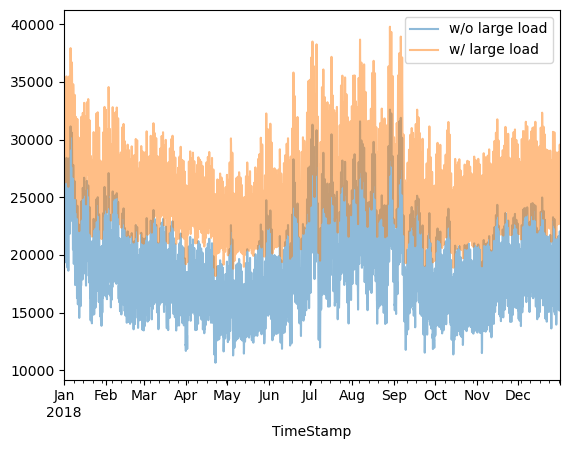

In [114]:
grid_profile_2030['load_profile'].sum(axis=1).plot(label='w/o large load', alpha=0.5)
load_profile_2030ContractCase.sum(axis=1).plot(label='w/ large load', alpha=0.5)
plt.legend()

## Plotting

In [115]:
if not os.path.exists(os.path.join(fig_dir, 'thermal_pg')):
    os.makedirs(os.path.join(fig_dir, 'thermal_pg'))

In [116]:
# Representative weeks
season_list = ['Winter', 'Spring', 'Summer', 'Autumn']

winter_week = ['2018-01-01', '2018-01-07']
spring_week = ['2018-04-02', '2018-04-08']
summer_week = ['2018-07-02', '2018-07-08']
autumn_week = ['2018-10-01', '2018-10-07']

week_list = [winter_week, spring_week, summer_week, autumn_week]

zone_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
              'NE', 'PJM', 'IESO', 'HQ']

In [117]:
# Change HQ import zone from 'D' and 'J' to 'HQ'
gen_prop = grid_prop_2030['gen_prop'].copy()
hq_idx = gen_prop[(gen_prop['GEN_ZONE'].isin(['D','J'])) & (gen_prop['UNIT_TYPE'] == 'Import')].index
gen_prop.loc[hq_idx, 'GEN_ZONE'] = 'HQ'

gen2zone_dict = gen_prop.set_index('GEN_NAME')[
    'GEN_ZONE'].to_dict()
esr2zone_dict = grid_prop_2030['esr_prop'].set_index('ESR_NAME')[
    'ESR_ZONE'].to_dict()
dclinef2zone_dict = grid_prop_2030['dcline_prop'].set_index('DC_NAME')[
    'FROM_ZONE'].to_dict()
dclinet2zone_dict = grid_prop_2030['dcline_prop'].set_index('DC_NAME')[
    'TO_ZONE'].to_dict()

In [118]:
gen_fuel_rename = {
    'NU_UR': 'Nuclear',
    'CC_NG': 'Combined Cycle (NG)',
    'ST_BIT': 'Steam Turbine (BIT)', 
    'ST_FO6': 'Steam Turbine (FO6)',
    'ST_NG': 'Steam Turbine (NG)',
    'CT_FO2': 'Combustion Turbine (FO2)',
    'CT_KER': 'Combustion Turbine (KER)',
    'CT_NG': 'Combustion Turbine (NG)',
    'Other_Other': 'Other',
    'Import_Import': 'Import (or Export)',
    'DCLine_F': 'DC Line (From)',
    'DCLine_T': 'DC Line (To)',
    'HY_WAT': 'Hydro',
    'PSH': 'Pumped Hydro Storage',
    'PV_SUN': 'Utility-scale PV',
    'LBW': 'Land-based Wind',
    'OSW': 'Offshore Wind',
    'BES': 'Battery Storage',
}

# Pumped hydro storage units
phs_names = [
    'Gilboa 1 (IIFO - 1/1/2019)', 'Gilboa 2', 
    'Gilboa 3', 'Gilboa 4', 'Lewiston PS'
]

# Offshore wind units
osw_names = [
    'Attentive Energy', 'Beacon Wind', 
    'Community Offshore Wind', 'Empire Offshore Wind',
    'Mid-Atlantic Offshore Wind', 'Sunrise Wind'
]

In [119]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030['PSH'] = pg_by_fuel_dict_2030['ESR'][phs_names].copy()

pg_by_fuel_dict_2030['BES'] = pg_by_fuel_dict_2030['ESR'].copy()
pg_by_fuel_dict_2030['BES'] = pg_by_fuel_dict_2030['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030['LBW'] = pg_by_fuel_dict_2030['WT_WND'].copy()
pg_by_fuel_dict_2030['LBW'] = pg_by_fuel_dict_2030['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030['OSW'] = pg_by_fuel_dict_2030['WT_WND'].copy()
pg_by_fuel_dict_2030['OSW'] = pg_by_fuel_dict_2030['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030['ST_BIT'] = pg_by_fuel_dict_2030['CC_NG'].drop(columns=pg_by_fuel_dict_2030['CC_NG'].columns)


### 1. Power generation by fuel type

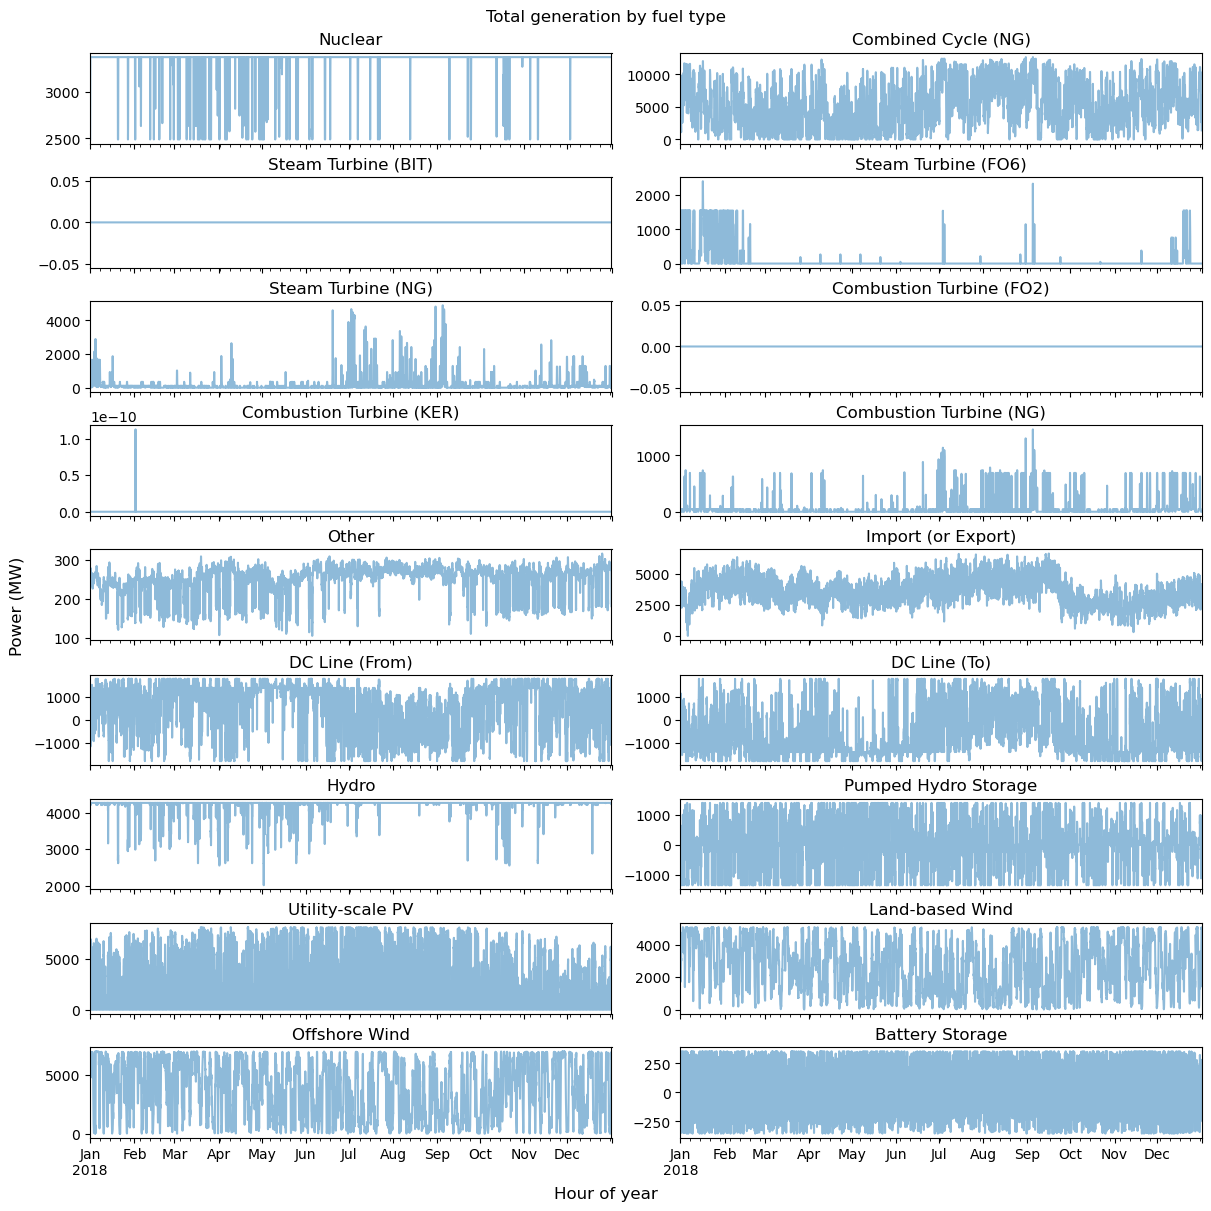

In [120]:
pg_by_fuel_sum = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    pg_by_fuel_sum[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum = pd.DataFrame(pg_by_fuel_sum,
                              index=pg_by_fuel_dict_2030['CC_NG'].index)

# Rename columns
pg_by_fuel_sum = pg_by_fuel_sum.rename(columns=gen_fuel_rename)

# Reorder columns
pg_by_fuel_sum = pg_by_fuel_sum[gen_fuel_rename.values()]

fig, axs = plt.subplots(pg_by_fuel_sum.shape[1]//2, 2, figsize=(12, 12),
                        layout='constrained', sharex=True)

for i, fuel_type in enumerate(pg_by_fuel_sum.columns):
    ax = axs.flatten()[i]
    pg_by_fuel_sum[fuel_type].plot(ax=ax, alpha=0.5, color='tab:blue')

    ax.set_title(fuel_type)

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
fig.suptitle('Total generation by fuel type')
plt.show()

In [121]:
pg_by_fuel_sum_by_zone = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    if fuel_type == 'DCLine_F':
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [dclinef2zone_dict], axis=1).sum().sum().to_dict()
    elif fuel_type == 'DCLine_T':
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [dclinet2zone_dict], axis=1).sum().sum().to_dict()
    elif fuel_type == 'ESR':
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [esr2zone_dict], axis=1).sum().sum().to_dict()
    else:
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [gen2zone_dict], axis=1).sum().sum().to_dict()
    pg_by_fuel_sum_by_zone[fuel_type] = pg_by_fuel_by_zone
    
pg_by_fuel_sum_by_zone = pd.DataFrame(pg_by_fuel_sum_by_zone)

# Add zone I
if 'I' not in pg_by_fuel_sum_by_zone.index:
    pg_by_fuel_sum_by_zone.loc['I'] = np.nan

# Rename columns
pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.rename(columns=gen_fuel_rename)

pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone[gen_fuel_rename.values()]

pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone/1e6 # Convert to TWh

pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.T[zone_order].T

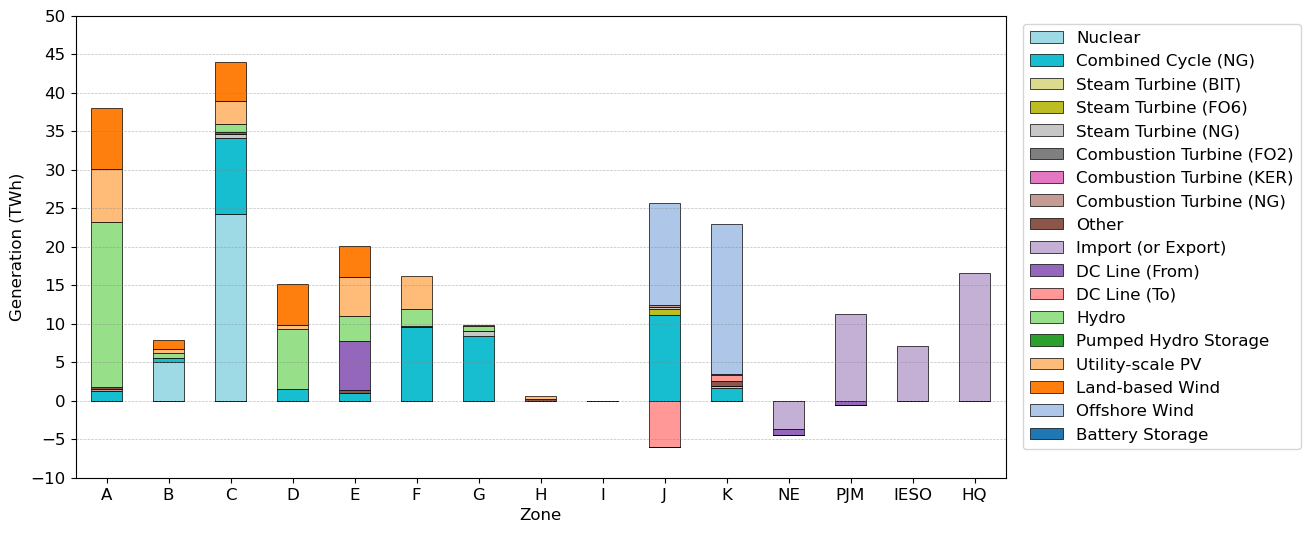

In [122]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

In [123]:
# Group by generator type and month
pg_by_fuel_sum_by_month = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    pg_by_fuel_by_month = pg_by_fuel.groupby(pg_by_fuel.index.month).sum().sum(axis=1).to_dict()
    pg_by_fuel_sum_by_month[fuel_type] = pg_by_fuel_by_month
    
pg_by_fuel_sum_by_month = pd.DataFrame(pg_by_fuel_sum_by_month)

# Rename columns
pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month.rename(columns=gen_fuel_rename)

pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month[gen_fuel_rename.values()]

pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month/1e6 # Convert to TWh


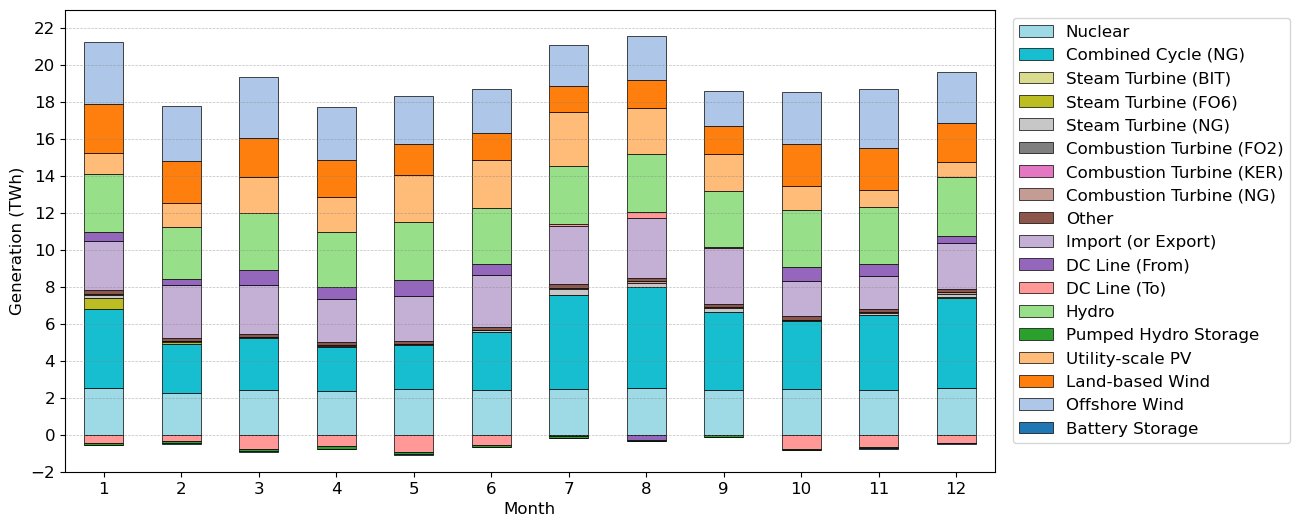

In [139]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

### 2. Check renewable curtailment

In [140]:
# UPV curtailment
# Maximum available UPV generation
upv_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(["PV_SUN"]).to_numpy()
upv_genmax_profile = grid_profile_2030['genmax_profile'].loc[:, upv_index]

# Calculate UPV curtailment
upv_curtailment = upv_genmax_profile - pg_by_fuel_dict_2030['PV_SUN']

# Aggregate UPV curtailment by zone
upv_curtailment_zone = upv_curtailment.groupby(
    [gen2zone_dict], axis=1).sum()

# Aggregate by month
upv_curtailment_zone_month = upv_curtailment_zone.groupby(
    upv_curtailment_zone.index.month).sum()

upv_curtailment_zone_month = upv_curtailment_zone_month/1e3 # Convert to GWh

# Add missing zones
for zone in zone_order[:11]:
    if zone not in upv_curtailment_zone_month.columns:
        upv_curtailment_zone_month[zone] = np.nan

# Reorder columns
upv_curtailment_zone_month = upv_curtailment_zone_month[zone_order[:11]]

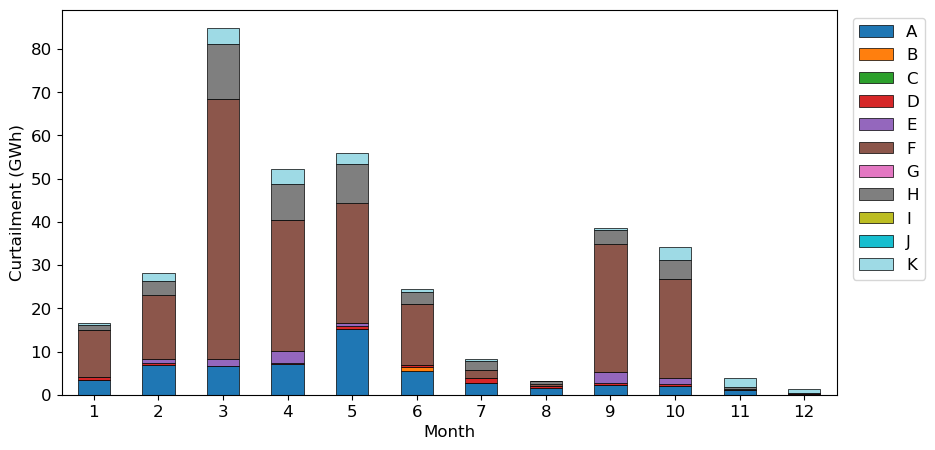

In [141]:
# Plot UPV curtailment
fig, ax = plt.subplots(figsize=(12, 6))
upv_curtailment_zone_month.plot(ax=ax, kind='bar', stacked=True, figsize=(10, 5),
                           colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Curtailment (GWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.axhline(0, color='black', lw=0.5, ls='--')
# ax.set_ylim(-1, 20)
plt.show()

In [142]:
# Wind curtailment
wind_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(["WT_WND"]).to_numpy()
wind_genmax_profile = grid_profile_2030['genmax_profile'].loc[:, wind_index]

# Calculate UPV curtailment
wind_curtailment = wind_genmax_profile - pg_by_fuel_dict_2030['WT_WND']

# Aggregate by zone
wind_curtailment_zone = wind_curtailment.T.groupby(gen2zone_dict).sum().T

# Aggregate by month
wind_curtailment_zone_month = wind_curtailment_zone.groupby(
    wind_curtailment_zone.index.month).sum()

wind_curtailment_zone_month = wind_curtailment_zone_month/1e3 # Convert to GWh

# Add missing zones
for zone in zone_order[:11]:
    if zone not in wind_curtailment_zone_month.columns:
        wind_curtailment_zone_month[zone] = np.nan

# Reorder columns
wind_curtailment_zone_month = wind_curtailment_zone_month[zone_order[:11]]

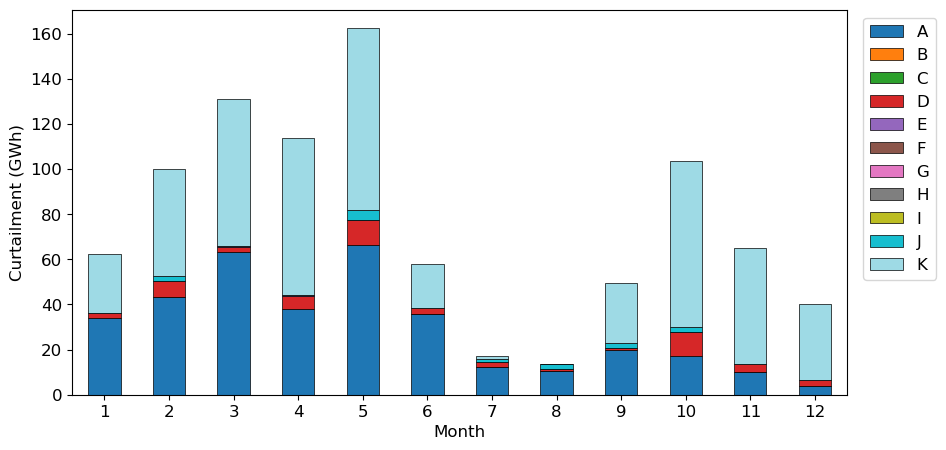

In [143]:
# Plot Wind curtailment
fig, ax = plt.subplots(figsize=(12, 6))
wind_curtailment_zone_month.plot(ax=ax, kind='bar', stacked=True, figsize=(10, 5),
                                 colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Curtailment (GWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.axhline(0, color='black', lw=0.5, ls='--')
# ax.set_ylim(-1, 20)
plt.show()

In [145]:
# Large Load curtailment
load_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(["Load_Load"]).to_numpy()
load_genmax_profile = grid_profile_2030['genmax_profile'].loc[:, load_index]

# Calculate UPV curtailment
load_curtailment = load_genmax_profile - pg_by_fuel_dict_2030['Load_Load']

# Aggregate by zone
load_curtailment_zone = load_curtailment.T.groupby(gen2zone_dict).sum().T

# Aggregate by month
load_curtailment_zone_month = load_curtailment_zone.groupby(
    load_curtailment_zone.index.month).sum()

load_curtailment_zone_month = load_curtailment_zone_month/1e3 # Convert to GWh

# Add missing zones
for zone in zone_order[:11]:
    if zone not in load_curtailment_zone_month.columns:
        load_curtailment_zone_month[zone] = np.nan

# Reorder columns
load_curtailment_zone_month = load_curtailment_zone_month[zone_order[:11]]

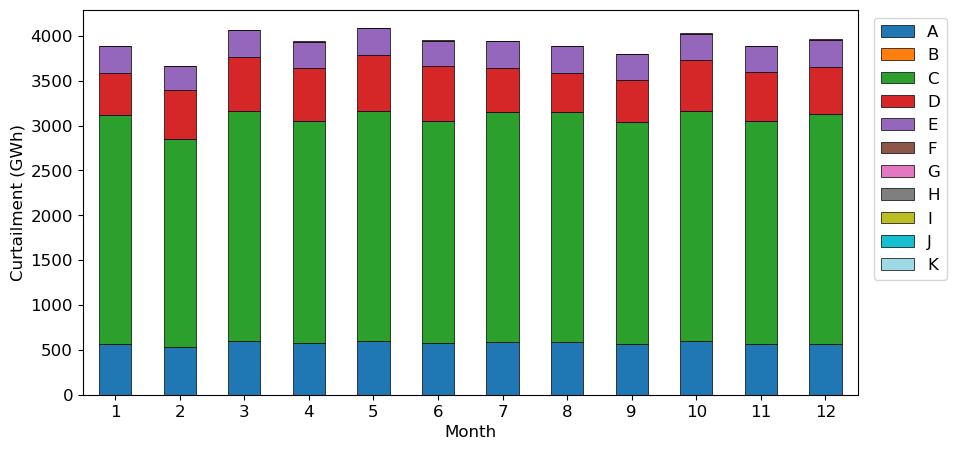

In [150]:
# Plot large load curtailment
fig, ax = plt.subplots(figsize=(12, 6))
load_curtailment_zone_month.plot(ax=ax, kind='bar', stacked=True, figsize=(10, 5),
                                 colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Curtailment (GWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.axhline(0, color='black', lw=0.5, ls='--')
# ax.set_ylim(-1, 20)
plt.show()

### 4. Check external generation and load

In [129]:
# External generator maximum generation profile
genmax_profile = grid_profile_2030['genmax_profile']

ne_cols = [col for col in genmax_profile.columns if 'NE' in col]
pjm_cols = [col for col in genmax_profile.columns if 'PJM' in col]
ieso_cols = [col for col in genmax_profile.columns if 'IESO' in col]
hq_cols = [col for col in genmax_profile.columns if 'HQ' in col]
genmax_ne_sum = genmax_profile[ne_cols].sum(axis=1)
genmax_pjm_sum = genmax_profile[pjm_cols].sum(axis=1)
genmax_ieso_sum = genmax_profile[ieso_cols].sum(axis=1)
genmax_hq_sum = genmax_profile[hq_cols].sum(axis=1)

genmax_profile_external_sum = genmax_ne_sum + genmax_pjm_sum \
    + genmax_ieso_sum + genmax_hq_sum

In [130]:
# External generator minimum generation profile
genmin_profile = grid_profile_2030['genmin_profile']

ne_cols = [col for col in genmin_profile.columns if 'NE' in col]
pjm_cols = [col for col in genmin_profile.columns if 'PJM' in col]
ieso_cols = [col for col in genmin_profile.columns if 'IESO' in col]
hq_cols = [col for col in genmin_profile.columns if 'HQ' in col]
genmin_ne_sum = genmin_profile[ne_cols].sum(axis=1)
genmin_pjm_sum = genmin_profile[pjm_cols].sum(axis=1)
genmin_ieso_sum = genmin_profile[ieso_cols].sum(axis=1)
genmin_hq_sum = genmin_profile[hq_cols].sum(axis=1)

genmin_profile_external_sum = genmin_ne_sum + genmin_pjm_sum \
    + genmin_ieso_sum + genmin_hq_sum

In [131]:
# External generation profile
pg_external = pg_by_fuel_dict_2030['Import_Import']
ne_cols = [col for col in pg_external.columns if 'NE' in col]
pjm_cols = [col for col in pg_external.columns if 'PJM' in col]
ieso_cols = [col for col in pg_external.columns if 'IESO' in col]
hq_cols = [col for col in pg_external.columns if 'HQ' in col]
pg_ne_sum = pg_external[ne_cols].sum(axis=1)
pg_pjm_sum = pg_external[pjm_cols].sum(axis=1)
pg_ieso_sum = pg_external[ieso_cols].sum(axis=1)
pg_hq_sum = pg_external[hq_cols].sum(axis=1)
pg_external_sum = pg_ne_sum + pg_pjm_sum + pg_ieso_sum + pg_hq_sum

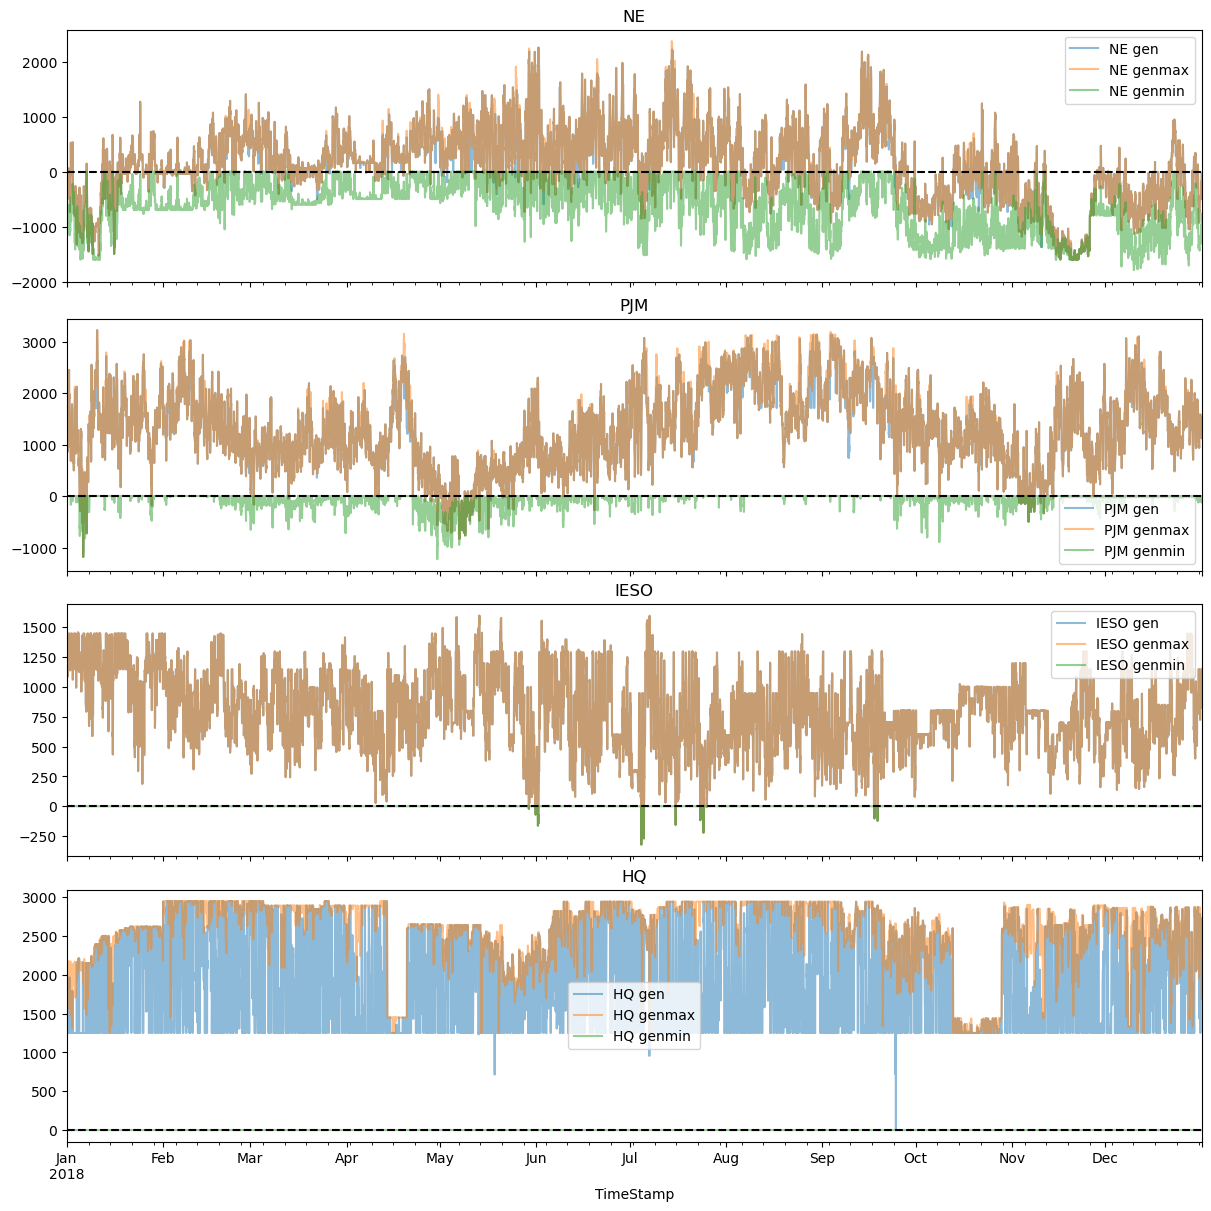

In [132]:
fig, axs = plt.subplots(4, 1, figsize=(
    12, 12), layout='constrained', sharex=True)

pg_ne_sum.plot(ax=axs[0], label='NE gen', alpha=0.5)
genmax_ne_sum.plot(ax=axs[0], label='NE genmax', alpha=0.5)
genmin_ne_sum.plot(ax=axs[0], label='NE genmin', alpha=0.5)
axs[0].set_title('NE')

pg_pjm_sum.plot(ax=axs[1], label='PJM gen', alpha=0.5)
genmax_pjm_sum.plot(ax=axs[1], label='PJM genmax', alpha=0.5)
genmin_pjm_sum.plot(ax=axs[1], label='PJM genmin', alpha=0.5)
axs[1].set_title('PJM')

pg_ieso_sum.plot(ax=axs[2], label='IESO gen', alpha=0.5)
genmax_ieso_sum.plot(ax=axs[2], label='IESO genmax', alpha=0.5)
genmin_ieso_sum.plot(ax=axs[2], label='IESO genmin', alpha=0.5)
axs[2].set_title('IESO')

pg_hq_sum.plot(ax=axs[3], label='HQ gen', alpha=0.5)
genmax_hq_sum.plot(ax=axs[3], label='HQ genmax', alpha=0.5)
genmin_hq_sum.plot(ax=axs[3], label='HQ genmin', alpha=0.5)
axs[3].set_title('HQ')

# pg_external_sum.plot(ax=axs[3], label='External gen', alpha=0.5)
# genmax_profile_external_sum.plot(ax=axs[3], label='External genmax', alpha=0.5)
# genmin_profile_external_sum.plot(ax=axs[3], label='External genmin', alpha=0.5)
# axs[3].set_title('External')

for ax in axs:
    ax.legend()
    ax.axhline(0, color='k', linestyle='--')

plt.show()

In [133]:
# fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
#                         layout='constrained')
# grid_profile_2018['load_profile'].sum(axis=1).plot(ax=axs[0], label='Load', alpha=0.5)
# pg_by_fuel_sum_2018.sum(axis=1).plot(ax=axs[0], label='Total generation', alpha=0.5)

# grid_profile_2030['load_profile'].sum(axis=1).plot(ax=axs[1], label='Load', alpha=0.5)
# pg_by_fuel_sum_2030.sum(axis=1).plot(ax=axs[1], label='Total generation', alpha=0.5)

# titles = ['2018 Baseline', '2030 CLCPA']
# for ax in axs.flatten():
#     ax.legend()
#     ax.set_title(titles.pop(0))
#     ax.grid()

In [134]:
# # Total thermal generation
# fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(thermal_pg_2018Baseline.sum(axis=1)/1e3, alpha=0.5, color='tab:blue',
#         label='2018 Baseline')
# ax.plot(thermal_pg_2030CLCPA.sum(axis=1)/1e3, alpha=0.5, color='tab:orange',
#         label='2030 CLCPA')

# ax.set_ylabel('Power (GW)', fontsize=16)
# ax.set_xlabel('Time', fontsize=16)
# ax.legend(fontsize=16)
# ax.tick_params(labelsize=16)
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.png'), 
# #             dpi=600, bbox_inches='tight', format='png')
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.svg'), 
# #             bbox_inches='tight', format='svg')


In [135]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 8),
#                         sharex=False, sharey=True)

# for i in range(4):
#     ax = axs.flatten()[i]
    
#     ax.plot(1/1e3*thermal_pg_2018Baseline.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.8, color='tab:blue', label='2018 Baseline')
#     ax.plot(1/1e3*thermal_pg_2030CLCPA.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.8, color='tab:orange', label='2030 CLCPA')

#     # Formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
#     # ax.set_ylim(0, 30)
#     ax.tick_params(axis='x', rotation=30)
#     ax.set_title(season_list[i], fontsize=20)
#     ax.grid(axis='x', linestyle='--')
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     if i == 1:
#             ax.legend(fontsize=16, loc='upper right')


# fig.supxlabel('Time', fontsize=20)
# fig.supylabel('Power (GW)', fontsize=20)
# # title = 'Total thermal generation in NYS'
# # fig.suptitle(title, fontsize=24)
# plt.tight_layout()
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
# #             dpi=600, bbox_inches='tight', format='png')
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
# #             bbox_inches='tight', format='svg')

### 5. LMP

In [136]:
# fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
#                         sharex='all', sharey='all')

# for i, ax in enumerate(axs.flat):
#     lmp_results_2018['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2018 Baseline', alpha=0.5)
#     lmp_results_2030['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2030 CLCPA', alpha=0.5)
#     ax.set_title(lmp_results_2018['LMP_by_zone'].columns[i])
#     ax.legend()

# fig.tight_layout()

In [137]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 8),
#                         sharex=False, sharey=True)

# for i in range(4):
#     ax = axs.flatten()[i]
    
#     ax.plot(lmp_results_2018['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2018 Baseline')
#     ax.plot(lmp_results_2030['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2030 CLCPA')

#     # Formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
#     # ax.set_ylim(0, 30)
#     ax.tick_params(axis='x', rotation=30)
#     ax.set_title(season_list[i], fontsize=20)
#     ax.grid(axis='x', linestyle='--')
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     if i == 1:
#             ax.legend(fontsize=16, loc='upper right')


# fig.supxlabel('Time', fontsize=20)
# fig.supylabel('LMP ($/MWh)', fontsize=20)
# # title = 'Total thermal generation in NYS'
# # fig.suptitle(title, fontsize=24)
# plt.tight_layout()
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
# #             dpi=600, bbox_inches='tight', format='png')
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
# #             bbox_inches='tight', format='svg')